In [ ]:
import _base_path
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
from resources.spans import SpanCollection, SpanExtractor
from resources.data_io import load_mappings
from resources.tokenization import WordTokenizer
from TrainerClassic import TrainerClassic

import matplotlib.pyplot as plt

In [2]:
MODEL  = 'tfidf-lr'
LABEL  = 'hazard-category'
DATA   = 'incidents'
COLUMN = f'{LABEL.split("-")[0]}-title'

# Load data:

In [3]:
# load data:
incidents = pd.read_csv(f"{DATA}/{DATA}.csv", index_col=0).drop(columns=[COLUMN])

# parse products:
incidents['product'].fillna('', inplace=True)
incidents['product-category'].fillna('', inplace=True)
incidents['product-text']     = [SpanCollection.parse(p) for p in incidents['product-text'].fillna('')]

# parse hazards:
incidents['hazard'].fillna('', inplace=True)
incidents['hazard-category'].fillna('', inplace=True)
incidents['hazard-text']      = [SpanCollection.parse(h) for h in incidents['hazard-text'].fillna('')]

# parse suppliers:
incidents['supplier-title']   = [SpanCollection.parse(s) for s in incidents['supplier-title'].fillna('')]
incidents['supplier-text']    = [SpanCollection.parse(s) for s in incidents['supplier-text'].fillna('')]

# fill nan-values:
incidents['country'].fillna('na', inplace=True)

def print_column(column:str, n:int=10):
    try:               values = np.unique(np.concatenate(incidents[column].values))
    except ValueError: values = np.unique(incidents[column].values)
    counts = np.array([sum([v in label for label in incidents[column].values]) for v in values])

    idx = np.argsort(counts)[::-1]
    values = values[idx]
    counts = counts[idx]
    
    print(f'Column "{column}" (n = {len(values):d}):\n')
    for v, n in zip(values[:n], counts[:n]):
        print(f'  {v}:{" "*(50-len(v))}{sum([v in label for label in incidents[column].values]):5d}')

# print unique counts:
for c in incidents.columns:
    print(f'  {c}:{" "*(20-len(c))}{len(incidents[c].drop_duplicates()):5d}')

  year:                   29
  month:                  12
  day:                    31
  url:                  7498
  title:                7329
  text:                 7546
  product:              1256
  product-raw:          1879
  product-category:       22
  product-text:         7546
  hazard:                261
  hazard-raw:            407
  hazard-category:        10
  hazard-text:          7546
  supplier-title:       7546
  supplier-text:        7546
  language:                6
  country:                15
  product-title:        4343


# Analysis:
## Extract Coefficients:

In [4]:
models, vocab = [], []
for i in range(5):
    t = TrainerClassic.load(f'../models/{MODEL}/{MODEL}-{LABEL}-{i:d}/')
    models.append(t._model)
    vocab.append(t.embedding.tokenizer._vocab)

# Row and column labels:
classes = load_mappings(f'{DATA}/splits/', LABEL)
counts = incidents[LABEL].value_counts()
classes = list(zip(
    classes,
    [counts[c] if c in counts else 0 for c in classes]
))
print(classes)

classes = [c for c, n in classes if n > 0]

tokens  = list(set(np.concatenate(vocab)))
tokens.sort()

# importance:
coefficients = np.zeros((len(classes), len(tokens)), dtype=float)
for m, v in zip(models, vocab):
    # create index-mapping: 
    idx = [tokens.index(t) for t in v]

    for i, c in enumerate(m.coef_):
        coefficients[i,idx] += c

# average over 5 splits:
coefficients /= 5.

C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[('allergens', 2527), ('biological', 2557), ('chemical', 578), ('food additives and flavourings', 32), ('food contact materials', 0), ('foreign bodies', 943), ('fraud', 527), ('migration', 14), ('organoleptic aspects', 81), ('other hazard', 187), ('packaging defect', 100)]


## Filter out all zero columns: 

In [5]:
idx = np.unique(np.nonzero(coefficients)[1])

coefficients_filtered = coefficients[:,idx]
tokens_filtered = [tokens[i] for i in idx]

In [6]:
# filter out numbers and special tokens:
i = list(tokens_filtered).index('a')
print(i)

tokens_filtered = tokens_filtered[i:]
coefficients_filtered = coefficients_filtered[:,i:]

108


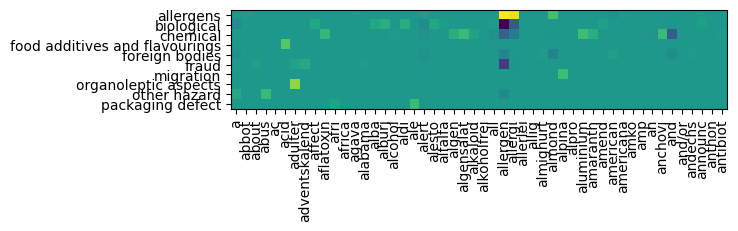

In [7]:
plt.imshow(coefficients_filtered[:50,:50])
plt.yticks(ticks=np.arange(min(len(classes), 50)), labels=classes[:50])
plt.xticks(ticks=np.arange(min(len(tokens_filtered), 50)), labels=tokens_filtered[:50], rotation=90)
plt.show()

## Calculate most important tokens:

In [8]:
most_important_tokens = {}

for i, c in enumerate(classes):
    idx = np.argsort(coefficients_filtered[i])[::-1]
    
    most_important_tokens[c] = {
        tokens_filtered[j]:coefficients_filtered[i,j]
        for j in idx
        if coefficients_filtered[i, j] > 0.
    }

In [9]:
for c in most_important_tokens:
    print(f'{c.upper()}: {", ".join(list(most_important_tokens[c].keys())[:10])}, ...')

ALLERGENS: undeclar, allergen, allergi, withdrawn, thereof, sultana, coconut, mustard, milk, chocol, ...
BIOLOGICAL: salmonella, listeria, risk, bacteria, mould, coli, noroviru, e., health, chees, ...
CHEMICAL: level, sibutramin, ethylen, chemic, oxid, sanit, cyanid, histamin, tadalafil, lead, ...
FOOD ADDITIVES AND FLAVOURINGS: jelli, high, withdraw, acid, cup, cure, haigh, tofu, colour, christma, ...
FOREIGN BODIES: foreign, metal, piec, plastic, insect, extran, glass, fragment, gerieben, minc, ...
FRAUD: without, inspect, unapprov, misbrand, english, inelig, report, mislabel, date, sweeten, ...
MIGRATION: migrat, nylon, schafskäs, fortun, silikon-muffinbackform, dot, aroy-d, aroma, alpina, holzgriff, ...
ORGANOLEPTIC ASPECTS: spoilag, rancid, uht, odour, off-odour, adulter, quality/spoilag, x, bratmax, still, ...
OTHER HAZARD: undercook, haccp, specifi, hazard, process, condit, prohibit, deviat, jelli, insuffici, ...
PACKAGING DEFECT: seal, fault, burst, apfelschorl, sparkl, wine, d

## Calculate overlap:

In [10]:
mit_all = np.concatenate([list(e.keys()) for e in most_important_tokens.values()])
mit_unique = np.unique(mit_all)

print(f'Overlap: {len(mit_all)/len(mit_unique):.2f}')

Overlap: 1.16


In [11]:
counts = {}
for mit in mit_unique:
    tmp = [key 
        for key in most_important_tokens
        if mit in most_important_tokens[key].keys()
    ]

    if len(tmp) > 1: counts[mit] = tmp

In [12]:
len(counts)

237

# Extract spans

In [13]:
tokenizer = WordTokenizer()
tokenizer._vocab.extend(tokens)
tokenizer.train = False

In [14]:
extractor = SpanExtractor(
    np.unique(incidents[LABEL.split('-')[0]].values),
    p_prefix=.5,
    p_suffix=.5,
    t_stopword=10
)
print('Prefixes:', extractor.prefixes)
print('Suffixes:', extractor.suffixes)


Prefixes: {'migration': 0.565, 'and': 0.5763888888888888, 'other': 0.8028571428571428, 'too': 0.9293849206349206, 'unauthorised': 0.6319223985890652, 'e': 0.6275793650793651, 'high': 0.8157879818594105, 'content': 0.6116307634164777, 'of': 0.500800051203277, 'substance': 0.5625}
Suffixes: {'thereof': 0.881060606060606, 'spp': 0.5249999999999999, 'product': 0.6036458333333333, 'colour': 0.54375}


In [15]:
data = []

for txt, lbl in incidents[['title', LABEL]].values:
    tok_out = tokenizer(txt, return_offsets_mapping=True)
    tkns = np.array([tokenizer._vocab[i] for i in tok_out['input_ids']])
    spns = tok_out['offset_mapping']

    importance = np.zeros(tkns.shape, dtype=float)
    for c in classes:
        for i, t in enumerate(tkns):
            if c == lbl:
                try: importance[i] += most_important_tokens[c][t]
                except KeyError: pass

            else:
                try: importance[i] -= most_important_tokens[c][t]
                except KeyError: pass

    spns = extractor.find([[t] for t in tkns[importance > 0]], txt)
    data.append((lbl, tkns[importance > 0], spns, importance[importance > 0]))

print(f'Percent of Texts with evidence for class: {np.mean([len(s) > 0 for _,_,s,_ in data])*100:.2f}%')

Percent of Texts with evidence for class: 86.92%


# Spans:

In [16]:
incidents[COLUMN] = [s for _,_,s,_ in data]

In [17]:
nlp = spacy.load("en_core_web_sm")

In [45]:
i = np.random.choice(incidents.index)
txt = nlp(incidents['title'].values[i])
txt.spans["sc"] = []

print(incidents[LABEL].values[i])
spans = [txt.char_span(l.start,l.stop, LABEL[:3].upper()) for l in incidents[COLUMN].values[i]]
for span in [incidents['title'].values[i][l] for l in incidents[COLUMN].values[i]]:
    print('[...]', span, '[...]')

#txt.set_ents(txt.ents + tuple([span for span in spans if span is not None]))
txt.spans["sc"] = tuple(txt.spans["sc"]) + tuple([span for span in spans if span is not None])

#displacy.render(txt, style='ent')
displacy.render(txt, style='span')

fraud
[...] label error [...]


# Save dataframe:

In [46]:
# concat products:
incidents['product-text']     = [str(p) for p in incidents['product-text']]

# concat hazards:
incidents['hazard-text']      = [str(h) for h in incidents['hazard-text']]

# concat suppliers:
incidents['supplier-title']   = [str(s) for s in incidents['supplier-title']]
incidents['supplier-text']    = [str(s) for s in incidents['supplier-text']]

incidents[COLUMN]             = [str(s) for s in incidents[COLUMN]]

incidents

,year,month,day,url,title,text,product,product-raw,product-category,product-text,hazard,hazard-raw,hazard-category,hazard-text,supplier-title,supplier-text,language,country,product-title,hazard-title
0,2015,5,26,https://www.fda.gov/Safety/Recalls/ArchiveReca...,2015 - House of Spices (India) Inc. Issues Ale...,"April 23, 2015 – Flushing, NY – House of Spic...",dried apricots,dried apricots,fruits and vegetables,"(108,119)|(442,453)|(748,759)",sulphur dioxide and sulphites,undeclared sulphite,allergens,"(33,50)|(98,99)|(240,241)|(738,739)|(820,821)","(7,33)","(33,50)|(98,99)|(240,241)|(738,739)|(820,821)",en,us,NaN,"(43,50)|(72,73)"
1,2022,5,25,https://www.fda.gov/safety/recalls-market-with...,Supplier J.M. Smucker Co.’s Jif Recall Prompts...,"(Miami, FL – May 24, 2022) - J.M. Smucker Co.’...",peanuts,peanuts,"nuts, nut products and seeds","(229,241)|(470,482)|(494,512)|(544,556)|(602,6...",salmonella,salmonella,biological,"(1,9)|(123,137)|(354,368)|(448,456)|(659,673)|...","(47,61)","(1,9)|(123,137)|(354,368)|(448,456)|(659,673)|...",en,us,"(28,30)|(85,90)","(0,7)|(47,51)|(131,140)"
2,2020,6,2,http://www.cfs.gov.hk/english/whatsnew/whatsne...,*(Updated on 2 June 2020) Not to consume a bat...,*(Updated on 2 June 2020) Not to consume a bat...,apple juice,apple juice,non-alcoholic beverages,"(52,70)|(222,240)|(341,345)|(556,560)|(1049,10...",patulin,patulin,chemical,"(354,365)|(581,592)|(1616,1620)",,"(354,365)|(581,592)|(1616,1620)",en,hk,"(72,76)","(96,102)"
3,2022,7,5,http://www.cfs.gov.hk/english/whatsnew/whatsne...,*(Updated on 5 July 2022) Not to consume smoke...,*(Updated on 5 July 2022) Not to consume smoke...,salmon,chilled smoked salmon,seafood,"(41,53)|(256,276)|(321,326)|(338,343)|(612,624...",listeria monocytogenes,listeria monocytogenes,biological,"(177,184)|(203,206)|(231,234)|(484,507)|(684,6...",,"(177,184)|(203,206)|(231,234)|(484,507)|(684,6...",en,hk,"(48,67)","(48,62)|(101,108)"
4,2021,3,20,http://www.fsis.usda.gov/recalls-alerts/avanza...,"Avanza Pasta, LLC Recalls Beef and Poultry Pro...",0009-2021\n\n \n High\n\n Produced Withou...,pasta products,pasta products,other food product / mixed,"(271,275)|(307,314)|(483,490)|(527,534)|(624,6...",inspection issues,inspection issues,fraud,"(264,280)|(617,633)|(730,734)|(2218,2238)|(325...","(0,16)","(264,280)|(617,633)|(730,734)|(2218,2238)|(325...",en,us,"(70,76)","(14,16)|(26,29)|(43,50)|(62,68)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7588,2015,10,30,http://www.foodstandards.gov.au/industry/foodr...,Mikko Ready Mix Coconut Milk Powder 150g,​Xiao Trading Pty Ltd has recalled Mikko Ready...,coconuts,coconut milk powder,fruits and vegetables,"(63,69)|(449,455)|(485,491)",milk and products thereof,milk and products thereof,allergens,"(0,20)|(885,904)",,"(0,20)|(885,904)",en,au,NaN,"(12,34)"
7589,2016,11,23,https://www.fda.gov/Safety/Recalls/ucm530611.htm,Recall Announcement: Sabra Dipping Company’s R...,“Fresh to Go Mediterranean Chicken Hummus” san...,sandwich spread,sandwich spread,"soups, broths, sauces and condiments","(351,358)|(969,976)|(1301,1308)|(1601,1608)|(1...",listeria monocytogenes,listeria monocytogenes,biological,"(212,225)|(499,507)|(979,987)|(1372,1380)|(170...",,"(212,225)|(499,507)|(979,987)|(1372,1380)|(170...",en,us,"(21,25)","(21,25)"
7590,2022,3,23,https://www.fda.gov/safety/recalls-market-with...,"Consumer Alert: Undeclared Sulfites in ""Licori...",“When a Government Agency Partner announces a ...,olives,olives,fruits and vegetables,"(445,450)|(754,759)|(1499,1504)",sulphates/sulphites,sulphates/sulphites,fraud,"(6,6)|(44,54)|(159,162)|(285,285)|(322,346)|(9...",,"(6,6)|(44,54)|(159,162)|(285,285)|(322,346)|(9...",en,us,NaN,
7591,2022,3,24,https://www.fda.gov/safety/recalls-market-with...,"Consumer Alert: Undeclared Sulfites in Dried ""...",“When a Government Agency Partner announces a ...,dried plums,dried plums,fruits and vegetables,"(434,438)|(754,758)|(1448,1452)",sulphates/sulphites,sulphates/

In [47]:
incidents.to_csv(f'{DATA}/{DATA}.csv')